In [1]:
import os
import json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from collections import defaultdict

def visualize_partitions(mode="unfiltered"):
    base_root = "app/temp"
    base_dir = os.path.join(base_root, mode)

    # Load free variables
    free_vars_path = os.path.join(base_root, "free_vars.json")
    with open(free_vars_path, 'r') as f:
        free_vars = set(json.load(f))

    # Load partition files
    files = sorted(
        [f for f in os.listdir(base_dir) if f.startswith("partition_") and f.endswith(".json")],
        key=lambda x: int(x.split('_')[1].split('.')[0])
    )

    print(f"Found {len(files)} partitions in '{mode}'")

    for path in files:
        print(f"\nReading {path}...")
        with open(os.path.join(base_dir, path), 'r') as file:
            data = json.load(file)

        G = nx.MultiDiGraph()
        edge_component = {}
        node_to_components = defaultdict(set)
        components = defaultdict(list)
        component_nodes = defaultdict(set)
        edge_occurrence = defaultdict(int)

        # Collect edges
        for edge in sorted(data, key=lambda e: (e['source'], e['label'], e['target'])):
            src, tgt, label = edge['source'], edge['target'], edge['label']
            comp_id = int(edge['component'])

            edge_occurrence[(src, tgt)] += 1
            key = edge_occurrence[(src, tgt)]
            G.add_edge(src, tgt, key=key, label=label)

            edge_component[(src, tgt, key)] = comp_id
            node_to_components[src].add(comp_id)
            node_to_components[tgt].add(comp_id)
            components[comp_id].append((src, label, tgt))
            component_nodes[comp_id].update([src, tgt])

        # Join nodes
        join_nodes = {n for n, comps in node_to_components.items() if len(comps) > 1 or n in free_vars}

        # Color map setup
        unique_components = sorted(components.keys())
        cmap = cm.get_cmap('tab10', len(unique_components))
        norm = mcolors.Normalize(vmin=0, vmax=len(unique_components) - 1)
        node_colors = ["red" if n in join_nodes else "lightgray" for n in G.nodes]

        # Layout
        plt.figure(figsize=(10, 7))
        pos = nx.kamada_kawai_layout(G)

        nx.draw_networkx_nodes(G, pos, node_size=500, node_color=node_colors)
        nx.draw_networkx_labels(G, pos)

        # --- Draw each directed edge separately (true directional visualization) ---
        counter = 0
        for (src, tgt, key, data) in G.edges(keys=True, data=True):
            comp_id = edge_component[(src, tgt, key)]
            color = cmap(norm(comp_id))

            # Compute curvature direction: opposite sign for reversed direction
            if hash(src) % 2 == 0:
                rad_sign = 1
            else:
                rad_sign = -1
            rad = 0.1 * rad_sign + counter # curvature magnitude

            # # If there are multiple parallel edges in same direction, offset more
            # parallel_count = len(G.get_edge_data(src, tgt))
            # if parallel_count > 1:
            #     rad += (key - (parallel_count + 1) / 2) * 0.5 * rad_sign

            nx.draw_networkx_edges(
                G, pos,
                edgelist=[(src, tgt)],
                connectionstyle=f'arc3,rad={rad}',
                edge_color=[color],
                arrows=True
            )

            # Label placement along the curve
            mid_x = (pos[src][0] + pos[tgt][0]) / 2
            mid_y = (pos[src][1] + pos[tgt][1]) / 2
            plt.text(
                mid_x + rad * 0.1,
                mid_y + rad * 0.1,
                data['label'],
                fontsize=8,
                color='black',
                bbox=dict(boxstyle="round,pad=0.1", fc="white", ec="none", alpha=0.7)
            )

            counter + 200

        # --- Annotate free variables ---
        x_vals = [p[0] for p in pos.values()]
        y_vals = [p[1] for p in pos.values()]
        x_range = max(x_vals) - min(x_vals)
        y_range = max(y_vals) - min(y_vals)
        offset_x = 0.07 * x_range
        offset_y = 0.07 * y_range

        for i, fv in enumerate(free_vars):
            if fv in pos:
                x, y = pos[fv]
                dx = offset_x * (1 + 0.3 * (i % 2))
                dy = offset_y * (1 if i % 2 == 0 else -1)
                plt.annotate(
                    "FREE",
                    xy=(x, y),
                    xytext=(x + dx, y + dy),
                    textcoords='data',
                    arrowprops=dict(
                        arrowstyle="->",
                        color='blue',
                        lw=1.5,
                        shrinkA=12,
                        shrinkB=6
                    ),
                    fontsize=9,
                    color='black',
                    fontweight='bold',
                    annotation_clip=False,
                    bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.7)
                )

        # --- Component annotation text ---
        comp_text_lines = []
        for cid in sorted(components):
            edges = components[cid]
            jn_in_comp = sorted(n for n in component_nodes[cid] if n in join_nodes)
            edge_repr = ", ".join(f"{src} -{label}-> {tgt}" for src, label, tgt in edges)
            comp_text_lines.append(
                f"Component {cid}:\n  Edges: {edge_repr}\n  Join Nodes: {', '.join(jn_in_comp) or 'None'}"
            )

        annotation_text = "\n\n".join(comp_text_lines)
        plt.gcf().text(0.02, 0.98, annotation_text, fontsize=9, verticalalignment='top', family='monospace')

        plt.title(f"Partition: {path}")
        plt.axis('off')
        plt.tight_layout()
        plt.show()


In [2]:
import os
import json
import hashlib

def hash_json_content(json_obj):
    """Generate a stable hash for a JSON object (sorted by keys)."""
    return hashlib.md5(json.dumps(json_obj, sort_keys=True).encode('utf-8')).hexdigest()

def load_json_hashes(folder_path):
    """Return a set of hashes for all JSONs in a folder."""
    hashes = set()
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as f:
                try:
                    data = json.load(f)
                    hashes.add(hash_json_content(data))
                except json.JSONDecodeError:
                    print(f"Skipping invalid JSON: {file_path}")
    return hashes

def find_differences(folder1, folder2):
    """Compare JSON contents between two folders."""
    set1 = load_json_hashes(folder1)
    set2 = load_json_hashes(folder2)

    only_in_1 = set1 - set2
    only_in_2 = set2 - set1

    print(f"Unique JSON contents in {folder1}: {len(only_in_1)}")
    print(f"Unique JSON contents in {folder2}: {len(only_in_2)}")

    return only_in_1, only_in_2


def show_unique_jsons(folder1, folder2):
    def hash_json_content(obj):
        import json, hashlib
        return hashlib.md5(json.dumps(obj, sort_keys=True).encode('utf-8')).hexdigest()

    def get_hash_map(folder):
        import os, json
        mapping = {}
        for f in os.listdir(folder):
            if f.endswith(".json"):
                with open(os.path.join(folder, f), 'r', encoding='utf-8') as j:
                    try:
                        data = json.load(j)
                        mapping[hash_json_content(data)] = f
                    except json.JSONDecodeError:
                        pass
        return mapping

    map1 = get_hash_map(folder1)
    map2 = get_hash_map(folder2)

    only_in_2 = set(map2.keys()) - set(map1.keys())
    if only_in_2:
        print("\nUnique JSONs in", folder2)
        for h in only_in_2:
            print("  →", map2[h])
    else:
        print("No unique JSONs in", folder2)


show_unique_jsons("app/temp/cpq", "app/temp/filtered")



No unique JSONs in app/temp/filtered


Found 12 partitions in 'filtered'

Reading partition_1.json...


/tmp/ipykernel_23834/2852694841.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_components))


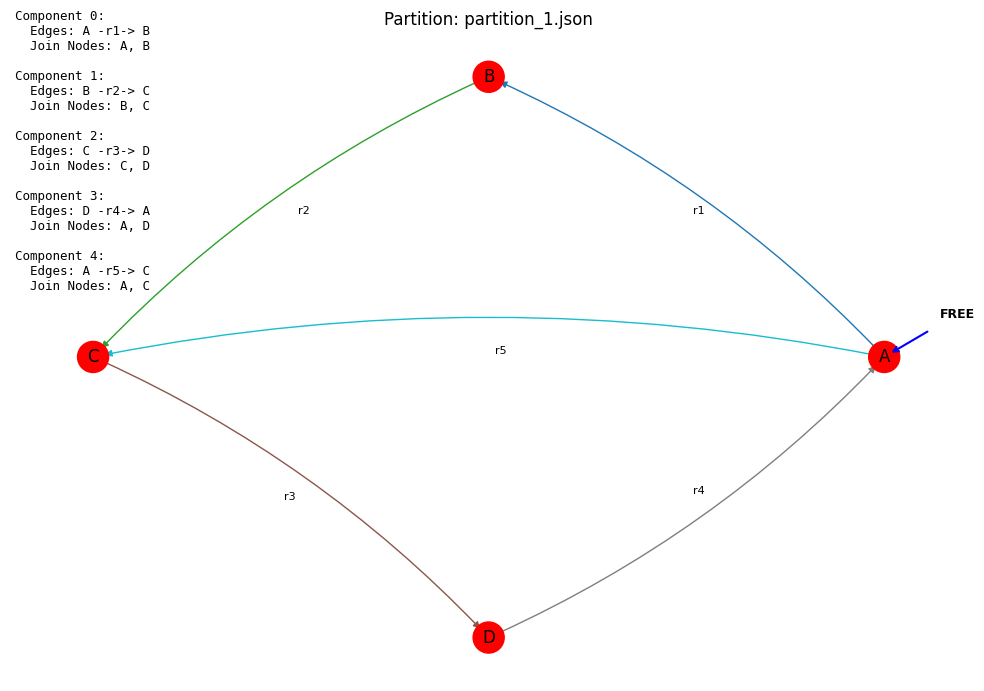


Reading partition_2.json...


/tmp/ipykernel_23834/2852694841.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', len(unique_components))


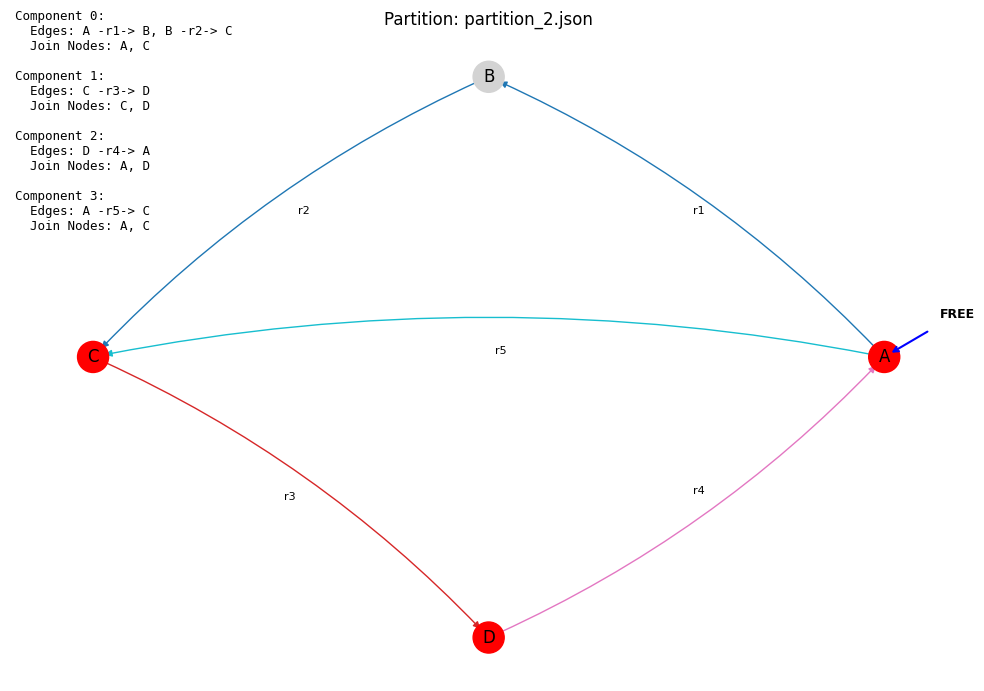


Reading partition_3.json...


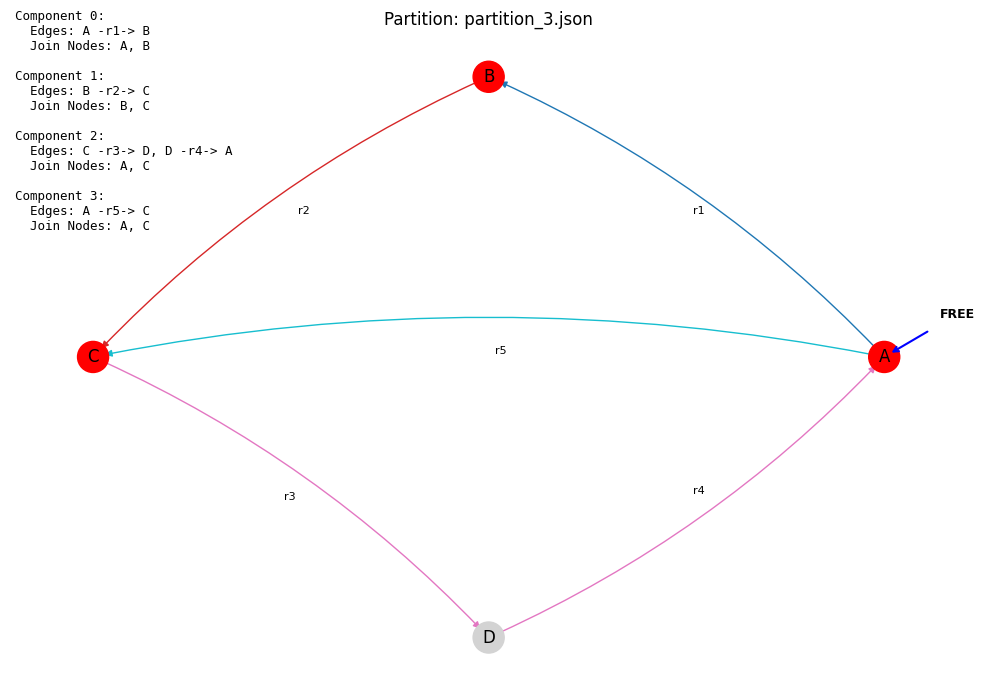


Reading partition_4.json...


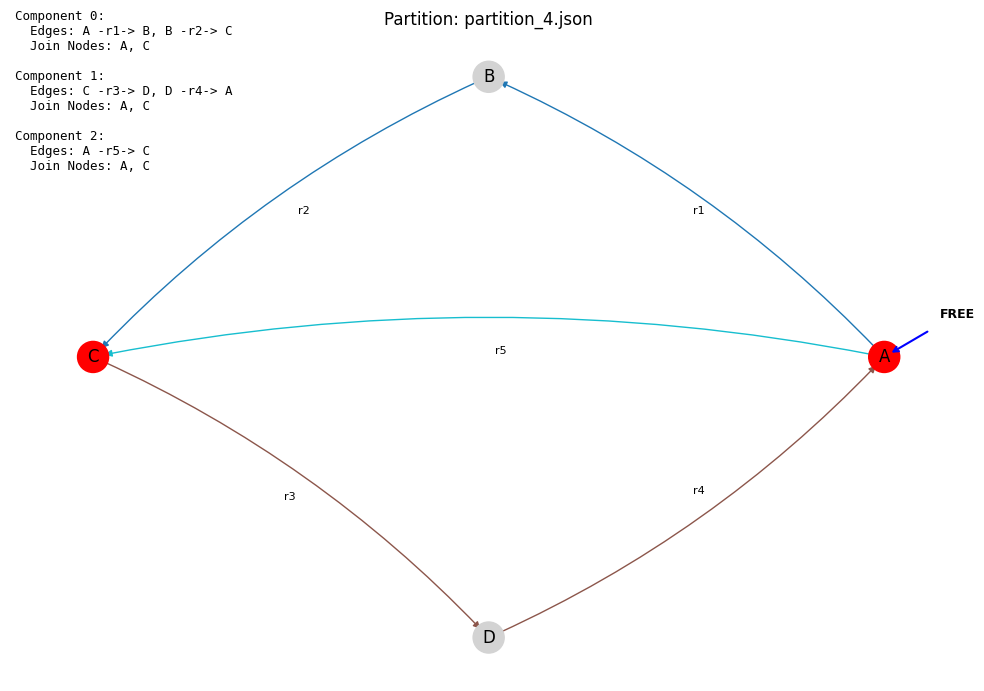


Reading partition_5.json...


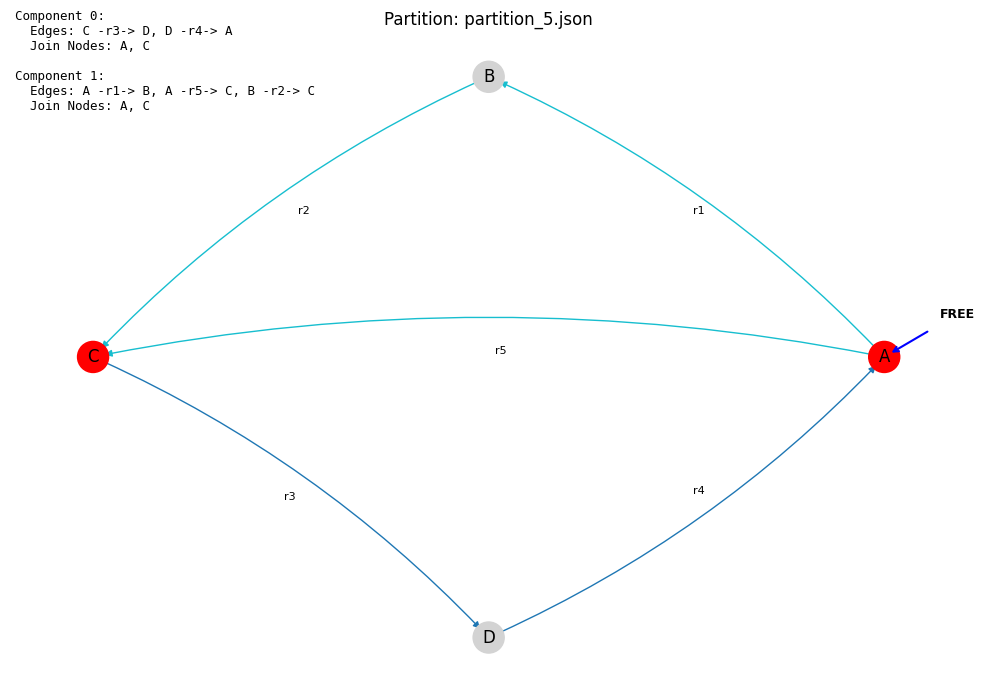


Reading partition_6.json...


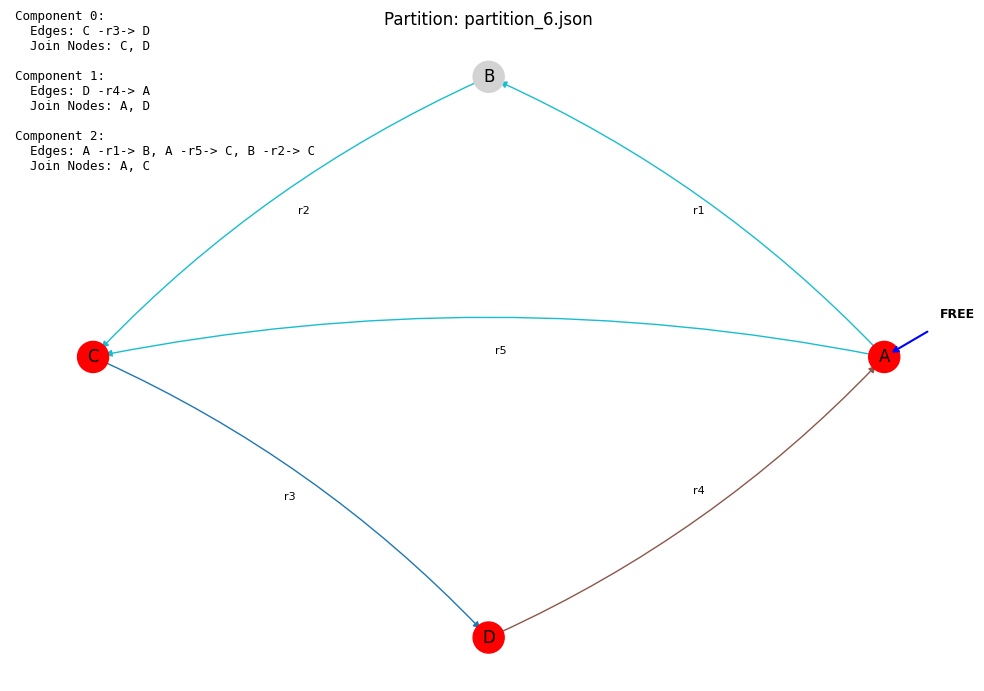


Reading partition_7.json...


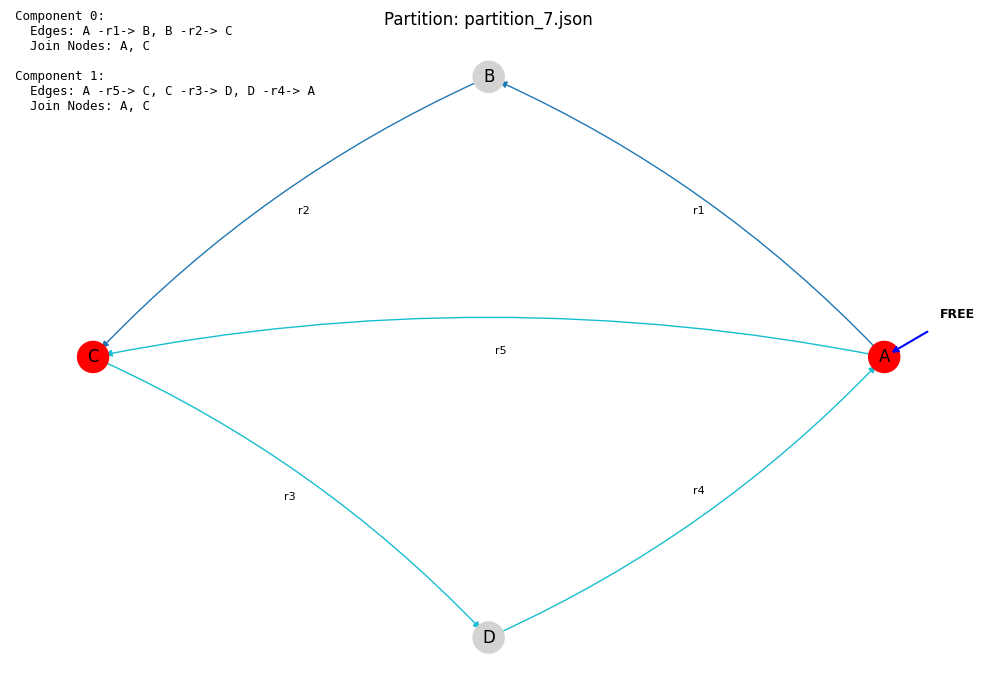


Reading partition_8.json...


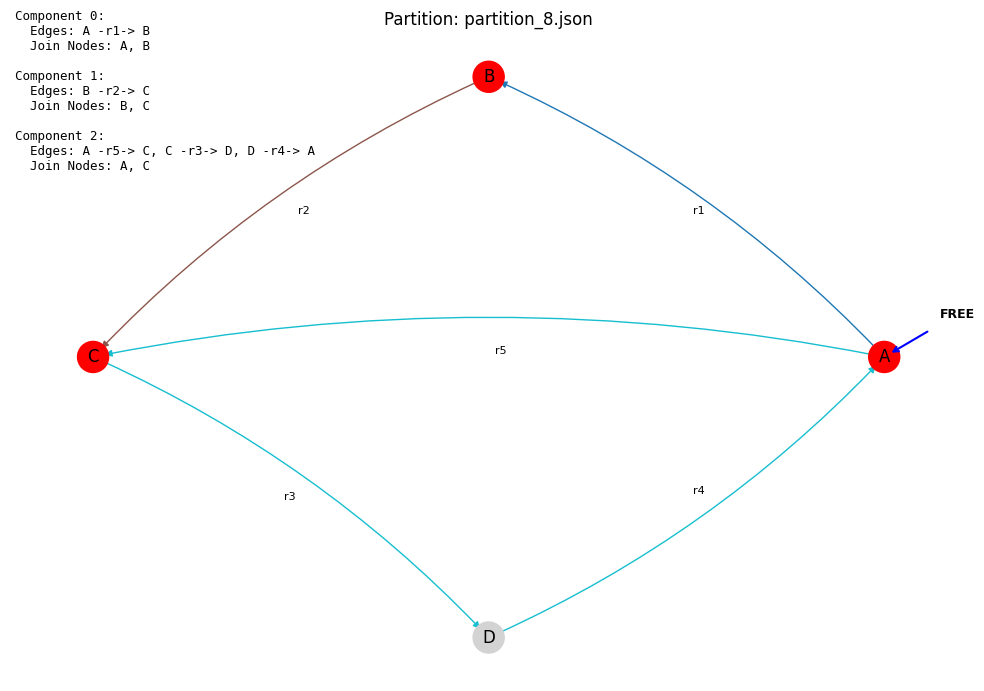


Reading partition_9.json...


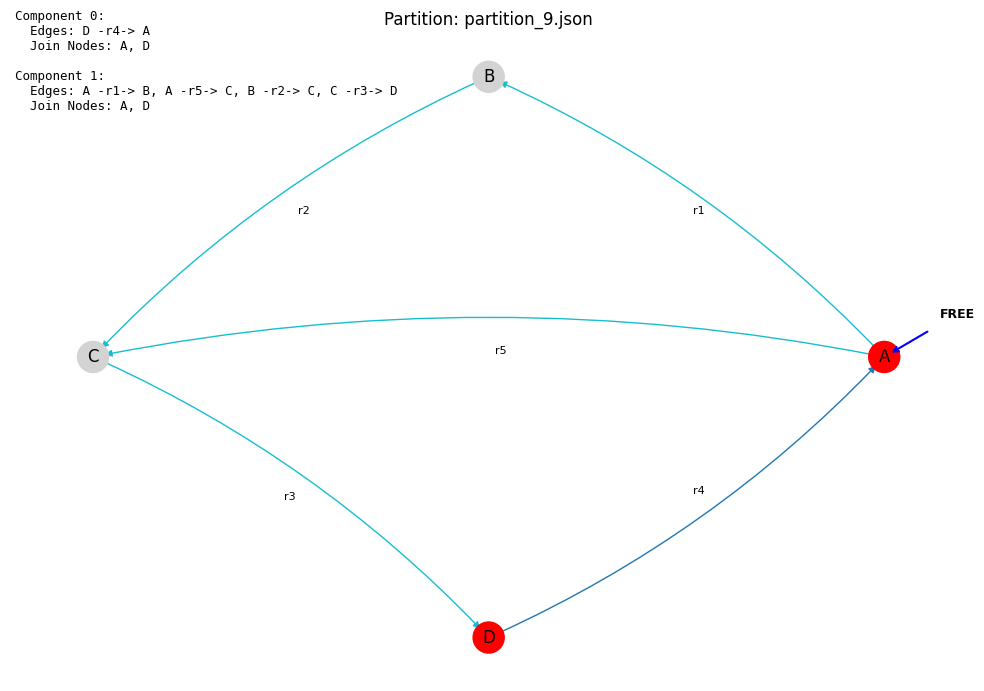


Reading partition_10.json...


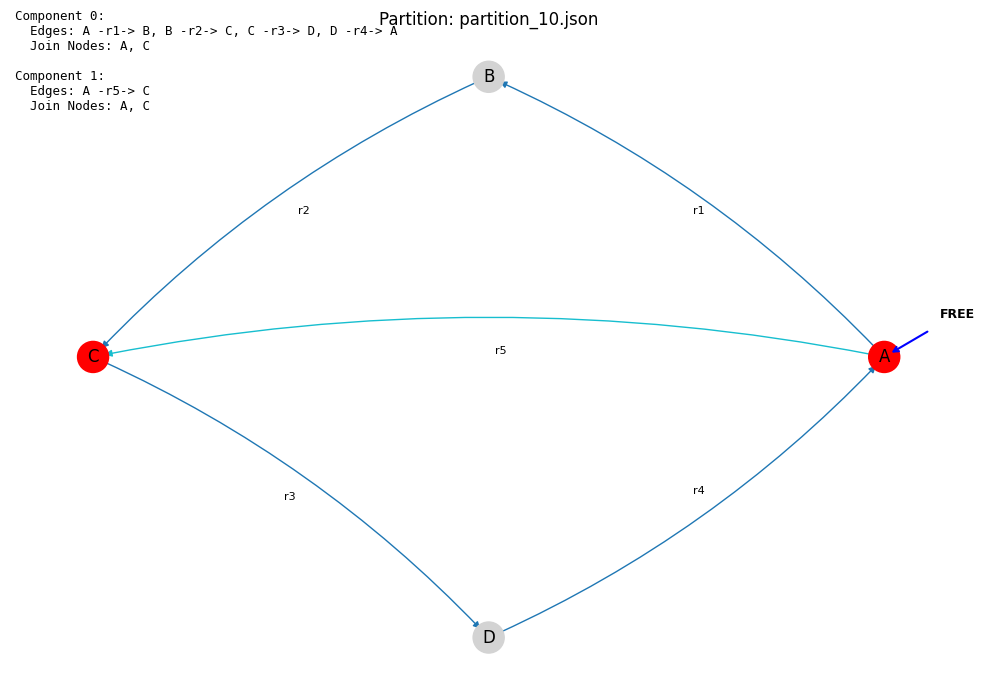


Reading partition_11.json...


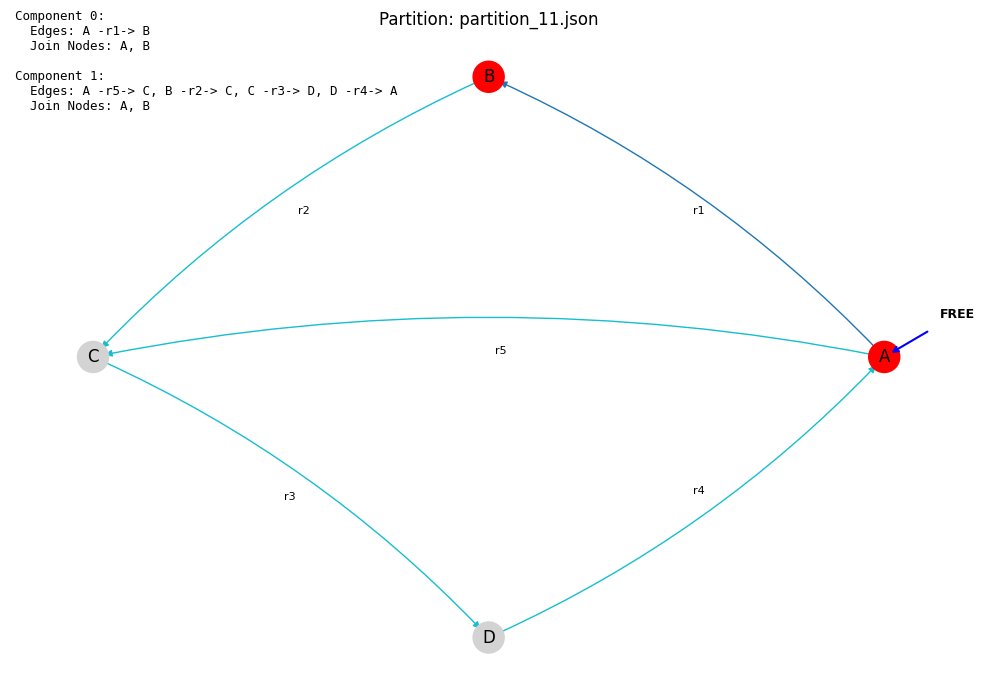


Reading partition_12.json...


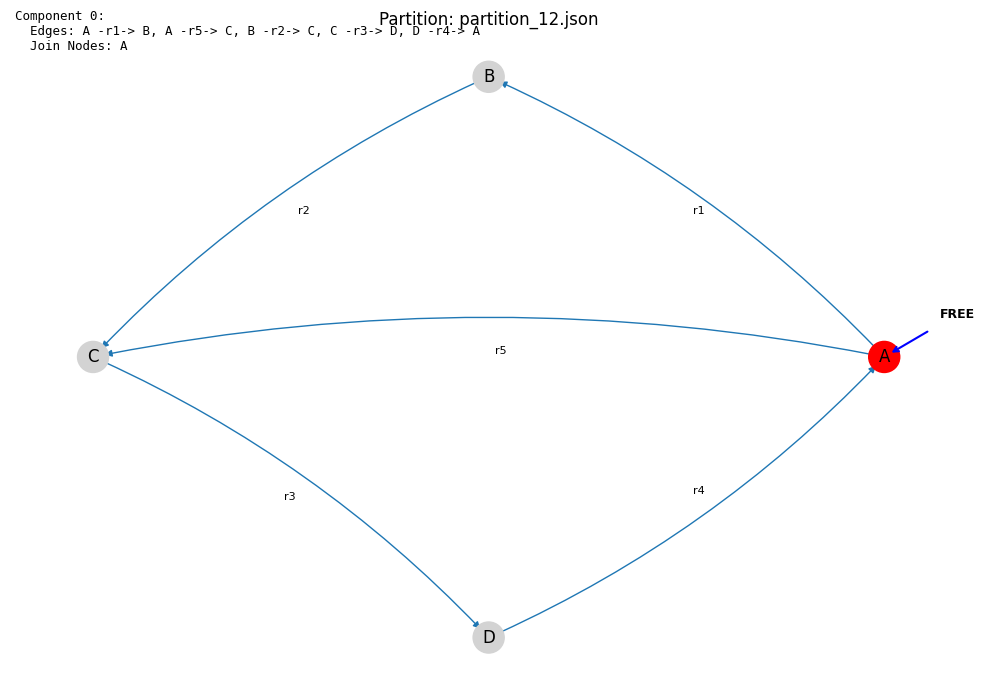

In [3]:
visualize_partitions("filtered")